# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models    
from collections import OrderedDict
from matplotlib import pyplot as plt
import argparse

import numpy as np
from PIL import Image

import json
import time

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
#Transforms for the training, validation, and testing sets
def load_data(data_dir='flowers'):
    data_dir = 'flowers'
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'
    test_dir = data_dir + '/test'
    
    train_transforms = transforms.Compose([transforms.RandomRotation(30),  #Rotate 30 degrees each way
                                           transforms.RandomResizedCrop(224), #Crop to 224 x 224 pixel
                                           transforms.RandomHorizontalFlip(), #Flip horizonally
                                           transforms.ToTensor(),  #Convert Tensor
                                           transforms.Normalize([0.485, 0.456, 0.406],  #Mean
                                                                [0.229, 0.224, 0.225])]) #Standard Dev

    test_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

    valid_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

    # Load the datasets with ImageFolder
    train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
    test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
    valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

    # Using the image datasets and the trainforms, define the dataloaders
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
    validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)

    return train_data, trainloader, testloader, validloader

train_data, trainloader, testloader, validloader=load_data(data_dir='flowers')

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [5]:
#Build network

# Use GPU if it's available - otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

# Load pre-trained model - vgg19
model = models.vgg19(pretrained=True)

# Function to build model - Arguments include model, inputs, 2 hidden inputs and outputs
def classifier(model, inputs, hidden1, hidden2, outputs):
    # 
    for param in model.parameters():
        param.requires_grad = False

    #List of different operations and pass a tensor through sequentially
    classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(inputs, hidden1)), #layer 1 
                            ('relu1', nn.ReLU()),
                            ('dropout1',nn.Dropout(0.5)),
                            ('fc2', nn.Linear(hidden1, hidden2)), #layer 2 
                            ('relu2',nn.ReLU()),
                            ('dropout2',nn.Dropout(0.5)),
                            ('fc3',nn.Linear(hidden2,outputs)),#output size = 102
                            ('output', nn.LogSoftmax(dim=1))]))# For using NLLLoss()
    return classifier



Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:04<00:00, 128259337.79it/s]


In [6]:
def build_model(model, inputs=25088, hidden1=4096, hidden2=1000, outputs=102, lr=0.01):

    # Run Classifer function and attach to model
    model.classifier = classifier(model, inputs, hidden1, hidden2, outputs)

    # Define Loss - negative likelihood loss
    criterion = nn.NLLLoss()

    # Optimiser - get the parameters from model, set learning rate
    optimiser = optim.Adam(model.classifier.parameters(), lr)

    #move our model to device e.g. cuda or cpu
    model.to(device)
    return model, criterion, optimiser

model, criterion, optimiser= build_model(model, inputs=25088, hidden1=4096, hidden2=1000, outputs=102)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [7]:
# Function to Train Network - Arguments include Epochs and validation step for when to run validation.
def train_network(epochs, validation_step):
    steps=0
    running_loss = 0
    
    for epoch in range(epochs):
        for images, labels in trainloader:
            steps += 1 #increment steps

            # Move input and label tensors to the default device
            images, labels = images.to(device), labels.to(device)
            optimiser.zero_grad() #zero out gradients
            output_logps = model.forward(images)             #Log probability from model with forward pass
            
            # Calculate loss and Increment
            loss = criterion(output_logps, labels) 
            loss.backward() #backwards pass - calculate gradient
            optimiser.step() #Adjust parameters
            running_loss += loss.item() 
            
           # Validation - For every Xth step - test networks accuracy and loss on validation data set.
            if steps % validation_step == 0:
                valid_loss = 0
                accuracy = 0
                model.eval() #turns off model inference mode - ie. turns off dropout so we can use network for make predictions
                with torch.no_grad(): #no grad turn off for validation 
                    # Validation loss
                    for images, labels in validloader: #get images and labels from validation data to do validation
                        images, labels = images.to(device), labels.to(device) #set to device
                        output_logps = model.forward(images) # get log probability from validation set
                        batch_loss = criterion(output_logps, labels) # get loss 
                        valid_loss += batch_loss.item() # keep track of loss on validation set
                    
                        # Calculate accuracy
                        probability = torch.exp(output_logps) #logps = returning softmax - log probability of classes
                        top_p, top_class = probability.topk(1, dim=1) #top 1 of each row (along columns)
                        equals = top_class == labels.view(*top_class.shape) #compares class to labels (reshapes labels tensor)
                        accuracy += equals.type(torch.FloatTensor).mean() #keeps track of mean
                        
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Training loss: {running_loss/print_every:.3f}.. " #average of training loss
                      f"Validation loss: {valid_loss/len(validloader):.3f}.. " # average loss - len(validloader) tells us how many batches we are getting
                      f"Validation accuracy: {accuracy/len(validloader):.3f}") #average accuracy - summing up accuracy for each batch / total number of batches 
                running_loss = 0 #set running loss back to 0
                model.train() #set model back into training mode 


In [ ]:
# Run function to train Network - set active session to True
active_session = True

while active_session:
    train_network(6, 5)  
    active_session = False

Epoch 1/1.. Training loss: 21.001.. Validation loss: 5.691.. Validation accuracy: 0.035
Epoch 1/1.. Training loss: 4.946.. Validation loss: 4.461.. Validation accuracy: 0.046
Epoch 1/1.. Training loss: 4.596.. Validation loss: 4.395.. Validation accuracy: 0.073
Epoch 1/1.. Training loss: 4.600.. Validation loss: 4.433.. Validation accuracy: 0.096
Epoch 1/1.. Training loss: 4.683.. Validation loss: 4.305.. Validation accuracy: 0.115
Epoch 1/1.. Training loss: 4.556.. Validation loss: 4.214.. Validation accuracy: 0.111
Epoch 1/1.. Training loss: 4.573.. Validation loss: 4.080.. Validation accuracy: 0.143
Epoch 1/1.. Training loss: 4.492.. Validation loss: 4.086.. Validation accuracy: 0.118
Epoch 1/1.. Training loss: 4.494.. Validation loss: 4.160.. Validation accuracy: 0.123


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# Function Test Network and print accuracy - Arguments include the model
def test_network(model, data_loader):
    accuracy = 0
    model.eval() #Turns off model inference mode

    #Turn off gradients for testing 
    with torch.no_grad(): 
        
        # Calculate accuracy and loss
        for images, labels in data_loader: #Get images and labels from test data to do validation
            images, labels = images.to(device), labels.to(device) #set to device
            output_logps = model.forward(images)  # get log probability from test set
            probability = torch.exp(output_logps) #logps = returning softmax - log probability of classes
            top_p, top_class = probability.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape) #compares class to labels
            accuracy += equals.type(torch.FloatTensor).mean()

        print( f"Test accuracy: {accuracy/len(data_loader):.3f}") #average accuracy - summing up accuracy for each batch / total number of batches 
        model.train() #set model back into training mode


In [ ]:
#Run Function to test model accuracy using Test Data
test_network(model, testloader)    

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
#Save the checkpoint 
def save_checkpoint(train_data, model, optimiser, path='checkpoint.pth', arch='vgg19', inputs=25088, hidden1=4096, hidden2=1000, outputs=102, epochs=2):
    model.class_to_idx = train_data.class_to_idx
    checkpoint = {'arch': arch,
                  'hidden1': hidden1,
                  'hidden2': hidden2,
                  'inputs': inputs,
                  'outputs': outputs,
                  'state_dict': model.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'optimiser_state': optimiser.state_dict(),
                  'epochs': epochs}
    torch.save(checkpoint, path)


save_checkpoint(train_data, model, optimiser, path='checkpoint.pth', arch='vgg19', inputs=25088, hidden1=4096, hidden2=1000, outputs=102, epochs=2)


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [28]:
# Function that loads a checkpoint and rebuilds the model - returns model, optimiser and also epochs

def load_checkpoint(filepath):
    criterion = nn.NLLLoss()
    checkpoint = torch.load(filepath)
    
    #Load Model with checkpoints
    model = models.vgg19(pretrained=True)
    model.classifier=classifier(model, checkpoint['inputs'], checkpoint['hidden1'], checkpoint['hidden2'], checkpoint['outputs'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    #Load Optimiser
    optimiser = optim.Adam(model.classifier.parameters(), lr=0.03)      
    optimiser.load_state_dict(checkpoint['optimiser_state'])
    
    epochs= checkpoint['epochs']
    
    return model, optimiser, epochs

# Reload model from checkpoint.pth file
model, optimiser, epochs = load_checkpoint('checkpoint.pth')
model


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [ ]:
# Optional - Reload to train network using epochs from checkpoint
train_network(epochs, 5):

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [18]:
#Function to process image
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open(image)
    
    img_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])
    


    # Transforms image   
    image_process =  img_transform(img)
    
    return image_process


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

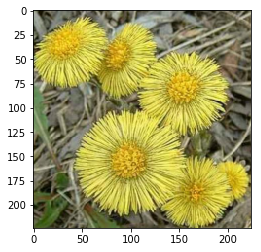

In [28]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image("flowers/test/12/image_03994.jpg"))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [20]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    with torch.no_grad():    # Turn off gradients
        device = torch.device('cuda' if torch.cuda.is_available() and device=='gpu' else 'cpu')
        model.eval()
        model.to(device) #set model to device
        
        # Run function to process image 
        image = process_image(image_path)    
        image = image.unsqueeze_(0)
        
        image.to(device) #set image to device

        output_logps = model.forward(image)  # Forward pass - get log probability 
        probability = torch.exp(output_logps) # Probability
        top_p, top_class = probability.topk(topk, dim=1)
        
        #Convert tensors to numpy array
        top_p=top_p.numpy() 
        top_class=top_class.numpy()

        # store class_to_idx values from modelin a dictionary
        idx_to_class = {model.class_to_idx[i]: i for i in model.class_to_idx} 
        classes = [idx_to_class[i] for i in top_class[0]] # Iterate get top classes
        probs = top_p[0] # get Probabilities 
    
        return probs, classes

    

In [21]:
# Run predict function and return probs and classes
image_path = 'flowers/test/16/image_06670.jpg'
top_k = 5
probs, classes= predict(image_path, model, top_k)
print(probs)
print(classes)


for i in classes:
    label = cat_to_name[i]
    prob = probs[i]
    print("Top {} Predictions...\n".format(top_k))
    print("Flower Name {} - Probability {}\n".format(prob))

[ 0.0119453   0.01107642  0.01103215  0.01080994  0.01079387]
['92', '16', '13', '93', '23']


# Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [121]:
# Function: Display an image along with the top classes
def display_predict(image_path, model, topk=5):
    
    #Based on image get probability of image
    probs, classes= predict(image_path, model, topk)

    #Get labels for top 5 - classes returned from predict function
    labels=[cat_to_name[i] for i in classes]

    # Plot flower and assign title
    image = Image.open(image_path)
    
    plt.figure(figsize = [5,10])
    img = plt.subplot(2,1,1)
    img.set_title(labels[0]) 
    img.imshow(image)

    # Plot probabilities bar graph
    plt.figure(figsize = [5,10]) 
    bar = plt.subplot(2,1,2)
    bar.set_yticks(np.arange(5)[::-1]) 
    bar.set_yticklabels(labels)
    bar.set_title("Predictions")
    bar.barh(np.arange(5)[::-1],probs)
    plt.show() # shows bar graph


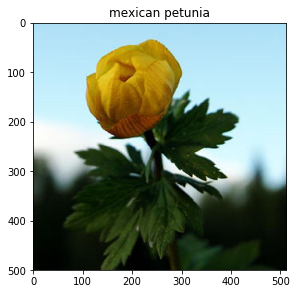

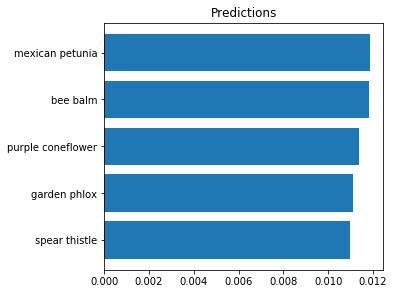

In [122]:
# Run check function with top 5 classes for image defined below
image_path = "flowers/test/37/image_03734.jpg"
check(image_path, model, topk=5)

<font color='red'>**Reminder for Workspace users:** If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.</font>

In [2]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace

In [1]:
# Arg Parser
def arg_parser():
    parser = argparse.ArgumentParser(description='Predict flower name.')
    parser.add_argument('image_path', help='Image Directory', action="store")
    parser.add_argument('--checkpoint', help='Checkpoint Path and File', dest="checkpoint", action="store", default="checkpoint.pth")
    parser.add_argument('--top_k', help='Top K', type=int, dest="top_k", action="store", default=5)
    parser.add_argument('--category_names', help='Category Names', dest="category_names", action="store", default='cat_to_name.json')
    parser.add_argument('--gpu', help='Use GPU', dest="gpu", action="store", default=None)
    args = parser.parse_args()
    return args


#Predict function to return top number of predictions for image
def predict(image_path, model, device, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    with torch.no_grad():    # Turn off gradients
        model.eval()
        model.to(device) #set model to device
        
        # Run function to process image 
        image = utils.process_image(image_path)    
        image = image.unsqueeze_(0)
        
        image.to(device) #set image to device

        output_logps = model.forward(image)  # Forward pass - get log probability 
        probability = torch.exp(output_logps) # Probability
        top_p, top_class = probability.topk(topk, dim=1)
        
        #Convert tensors to numpy array
        top_p=top_p.numpy() 
        top_class=top_class.numpy()

        # store class_to_idx values from modelin a dictionary
        idx_to_class = {model.class_to_idx[i]: i for i in model.class_to_idx} 
        classes = [idx_to_class[i] for i in top_class[0]] # Iterate get top classes
        probs = top_p[0] # get Probabilities 
    
        return probs, classes # return probabilities and classes

# Function: Display an image along with the top classes
def display_predict(image_path, model, device, cat_to_name, topk=5):
    
    #Run Predict Function - Based on image get probability of image
    probs, classes = predict(image_path, model, device, topk)

    #Get labels for top 5 - classes returned from predict function and store in list
    labels = [cat_to_name[i] for i in classes]

    # Plot flower and assign title
    image = Image.open(image_path)
    plt.figure(figsize = [5,10])
    img = plt.subplot(2,1,1)
    img.set_title(labels[0]) #Set Title to Top 1 from predict classes
    img.imshow(image)

    # Plot probabilities bar graph
    plt.figure(figsize = [5,10]) 
    bar = plt.subplot(2,1,2)
    bar.set_yticks(np.arange(topk)[::-1]) #set yticks to topk order desc
    bar.set_yticklabels(labels) #Apply ytick labels
    bar.set_title("Predictions")
    bar.barh(np.arange(topk)[::-1],probs)
    plt.show() # shows bar graph


def main():
    #Load arguments
    image_path = "flowers/test/37/image_03734.jpg"
    checkpoint = "checkpoint.pth"
    top_k = 5
    category_names = cat_to_name
    device = torch.device("cuda" if args.gpu == "gpu" and torch.cuda.is_available() else "cpu")  
 
    #Load Saved Checkpoint
    if os.path.isfile(checkpoint)       
        model, optimiser, epochs = utils.load_checkpoint(checkpoint)
    else: 
        Print("Checkpoint file {} does not exist".format(checkpoint)) 
        return

    # Predict Probabilities and display image and bar graph based on topK
    if os.path.exists(image_path):    
        display_predict(image_path, model, device, cat_to_name, top_k)
    else: 
        Print("Image Path {} does not exist".format(image_path))   
        return

    #Load category names
    if os.path.isfile(category_names)     
        cat_to_name = utils.load_labels(category_names)    
    else: 
        Print("Category Names file {} does not exist".format(checkpoint))  
        return
    


GPU is available


In [9]:
if __name__ == '__main__': main()  

    100% |████████████████████████████████| 881.9MB 43kB/s  eta 0:00:01  4% |█▍                              | 38.7MB 68.5MB/s eta 0:00:13    35% |███████████▎                    | 310.8MB 69.0MB/s eta 0:00:09    39% |████████████▋                   | 348.5MB 65.9MB/s eta 0:00:09    40% |█████████████                   | 356.0MB 62.8MB/s eta 0:00:09    42% |█████████████▌                  | 373.2MB 66.0MB/s eta 0:00:08    44% |██████████████▍                 | 395.4MB 64.3MB/s eta 0:00:08    46% |███████████████                 | 411.6MB 67.0MB/s eta 0:00:08    46% |███████████████                 | 412.4MB 64.8MB/s eta 0:00:08    51% |████████████████▌               | 455.2MB 70.8MB/s eta 0:00:07    52% |████████████████▊               | 461.9MB 61.7MB/s eta 0:00:07[K    53% |█████████████████▎              | 474.9MB 60.4MB/s eta 0:00:07    58% |██████████████████▋             | 514.4MB 67.9MB/s eta 0:00:06    60% |███████████████████▎            | 532.2MB 62.8MB/s eta 0:00:06    61% 

NameError: name 'nvcc' is not defined